## **Identifying Fraudulent Transactions:**  

**Objective of the Project:**

The objective of this project is to build a predictive model that classifies whether a given transaction is fraudulent or legitimate.

Detecting fraudulent transactions is critical in the financial and banking sectors to minimize monetary losses, protect customers, and maintain trust.

**Business Goal:**

Maximize fraud detection accuracy (high recall) while maintaining a low false positive rate (balanced precision-recall trade-off).


I imported the jsonlines library because the data is stored in Json Lines format, where each line was a separate JSON object.
This library helps read and process the data easily and efficiently, especially when working with large files.

In [50]:
pip install jsonlines


In [51]:
import jsonlines
import pandas as pd
from datetime import datetime
#import sys
#print(sys.executable)

data = []

with jsonlines.open("/content/transactions data.txt") as reader:
  for obj in reader.iter(skip_invalid=True): # Used Skip_invalid as True to ignore any error related to extra characters after valid JSON Object
    data.append(obj)

data = pd.DataFrame(data)



## **Data Over View and Cleaning**:

In [52]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22981 entries, 0 to 22980
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   accountNumber                 22981 non-null  object 
 1   customerId                    22981 non-null  object 
 2   creditLimit                   22981 non-null  float64
 3   availableMoney                22981 non-null  float64
 4   transactionDateTime           22981 non-null  object 
 5   transactionAmount             22981 non-null  float64
 6   merchantName                  22981 non-null  object 
 7   acqCountry                    22981 non-null  object 
 8   merchantCountryCode           22980 non-null  object 
 9   posEntryMode                  22979 non-null  object 
 10  posConditionCode              22979 non-null  object 
 11  merchantCategoryCode          22979 non-null  object 
 12  currentExpDate                22979 non-null  object 
 13  a

In [5]:
# Count unique values in each column
unique_counts = data.nunique()

# Display the result
print("Unique value count per column:")
print(unique_counts)

Unique value count per column:
accountNumber                 163
customerId                    163
creditLimit                    10
availableMoney              16805
transactionDateTime         18943
transactionAmount           12916
merchantName                 2018
acqCountry                      5
merchantCountryCode             5
posEntryMode                    6
posConditionCode                4
merchantCategoryCode           19
currentExpDate                165
accountOpenDate               153
dateOfLastAddressChange       209
cardCVV                       218
enteredCVV                    315
cardLast4Digits               247
transactionType                 4
echoBuffer                      1
currentBalance              16700
merchantCity                    1
merchantState                   1
merchantZip                     1
cardPresent                     2
posOnPremises                   1
recurringAuthInd                1
expirationDateKeyInMatch        2
isFraud          

#### **Missing Values and Empty Strings**:
The dataset was first checked for missing values using the isnull().sum() method.
Additionally, some columns contained empty strings or whitespace characters instead of actual null values. Regular expressions (Regex) were used to detect and handle such columns appropriately.

In [6]:
# Check remaining missing values
missing_summary = data.isnull().sum()
print(missing_summary)

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64


In [7]:
import numpy as np

empty_counts_sum = data.replace(r'^\s*$', np.nan, regex=True).isna().sum()
print(empty_counts_sum[empty_counts_sum > 0])


acqCountry               111
merchantCountryCode       14
posEntryMode             121
posConditionCode          14
transactionType           15
echoBuffer             18950
merchantCity           18950
merchantState          18950
merchantZip            18950
posOnPremises          18950
recurringAuthInd       18950
dtype: int64


/tmp/ipython-input-1560404081.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_counts_sum = data.replace(r'^\s*$', np.nan, regex=True).isna().sum()


<Axes: xlabel='isFraud', ylabel='transactionAmount'>

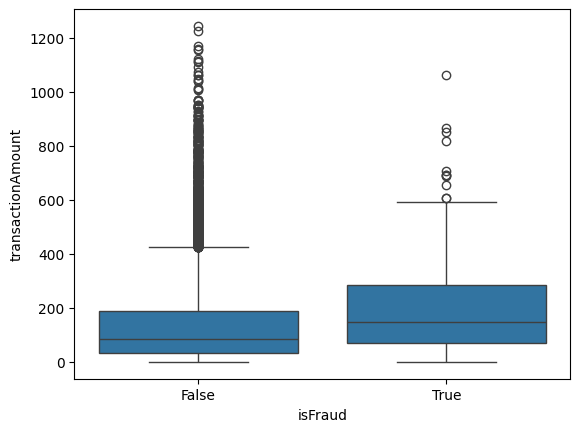

In [8]:
import seaborn as sns
sns.boxplot(x='isFraud', y='transactionAmount', data=data)


**Some columns — like echoBuffer, merchantCity, merchantState, merchantZip, posOnPremises, and recurringAuthInd — contained only empty or missing values.
Since they don’t provide any useful information for fraud detection and would only increase processing time and memory usage, I decided to remove them from the dataset.**

In [9]:

data = data.drop(columns=['customerId'])

In [10]:
cols_to_drop = [
    'echoBuffer', 'merchantCity', 'merchantState',
    'merchantZip', 'posOnPremises', 'posConditionCode',  'recurringAuthInd'
]
data = data.drop(columns=cols_to_drop)

In [11]:
import pandas as pd

date_cols = ["dateOfLastAddressChange", "accountOpenDate", "currentExpDate", "transactionDateTime"]

# Convert columns to datetime
for col in date_cols:
    data[col] = pd.to_datetime(data[col], errors="coerce")  # coerce will set invalid parsing to NaT

# Check result
print(data[date_cols].dtypes)


dateOfLastAddressChange    datetime64[ns]
accountOpenDate            datetime64[ns]
currentExpDate             datetime64[ns]
transactionDateTime        datetime64[ns]
dtype: object


/tmp/ipython-input-4151465552.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col], errors="coerce")  # coerce will set invalid parsing to NaT


### **Exploratory Data Analysis:**

**Checking Skewness and Outliers**:



creditLimit          2.459459
availableMoney       2.912839
transactionAmount    2.040563
currentBalance       4.211631
dtype: float64


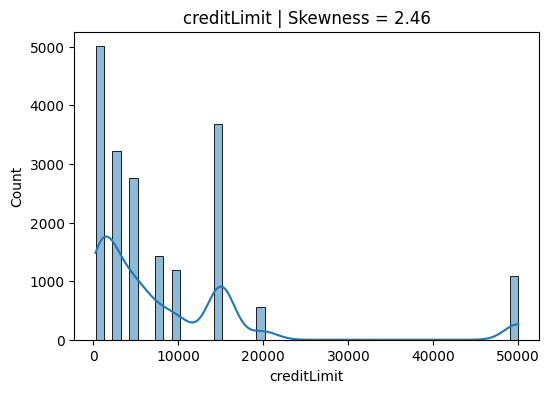

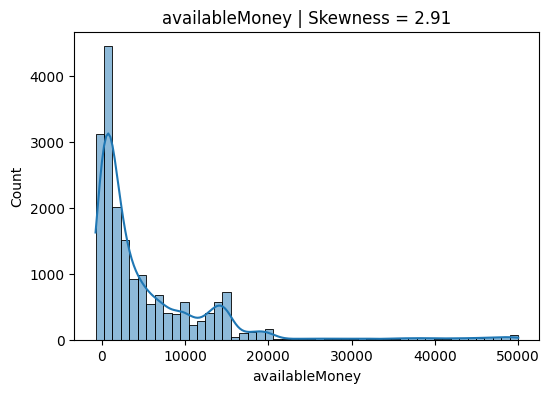

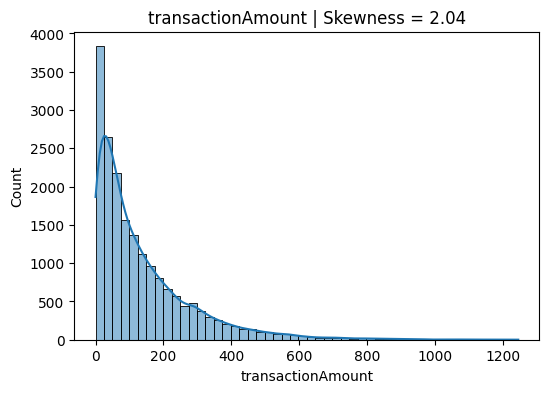

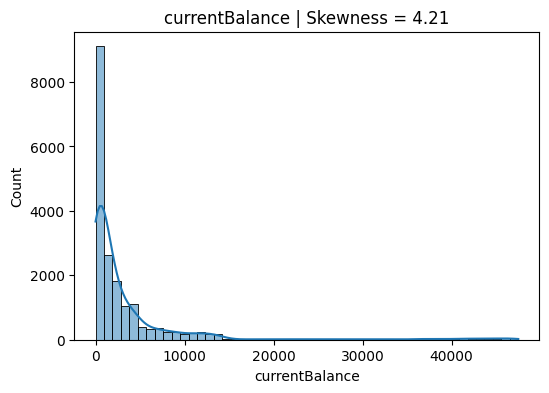

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']

# Calculate skewness
skew_vals = data[num_cols].skew()
print(skew_vals)

# Plot histograms + KDE for visualization
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], kde=True, bins=50)
    plt.title(f"{col} | Skewness = {data[col].skew():.2f}")
    plt.show()


The variables - Current Amount, Transaction Amount, Available Money are rightly skewed and  applying log1p transformation will help us in removing skewness and make data ditribution normal.  

**Analyzing the Impact of CVV Mismatch on Fraudulent Transactions**

In [13]:
# Create new column checking equality
data['cvv_match'] = data['cardCVV'] == data['enteredCVV']
data['cvv_match'].value_counts()


,count
cvv_match,
True,18784
False,166


In [14]:
# Filter mismatches
mismatches = data.loc[~data['cvv_match']]

# Group by merchant and count mismatches
merchant_mismatch_counts = mismatches.groupby('merchantCategoryCode').size().reset_index(name='mismatch_count').sort_values(by='mismatch_count', ascending=False)

print(merchant_mismatch_counts)

    merchantCategoryCode  mismatch_count
9          online_retail              39
3               fastfood              29
12             rideshare              20
2          entertainment              17
5                 health              14
4                   food              13
11         personal care               9
7             mobileapps               8
8           online_gifts               6
1                   auto               3
13         subscriptions               3
6                 hotels               2
10  online_subscriptions               2
0                airline               1


The merchant category analysis revealed significant data mismatches, particularly in Online Retail (152), Fast Food (90), and Food (61). Such inconsistencies may be indicative of fraudulent behavior, as high-frequency or online transactions are often used by fraudsters to test stolen cards.

These mismatches could arise from card-not-present activities. These categories should be prioritized for anomaly detection or model-based fraud risk scoring.

Conversely, categories like Airline and Fuel show lower mismatch counts, suggesting greater consistency and lower immediate fraud risk.

In [15]:
data = data.drop(columns=['cardCVV', 'enteredCVV', 'cardLast4Digits'])

### **Analyzing Fraud Rate by POS Entry Mode**

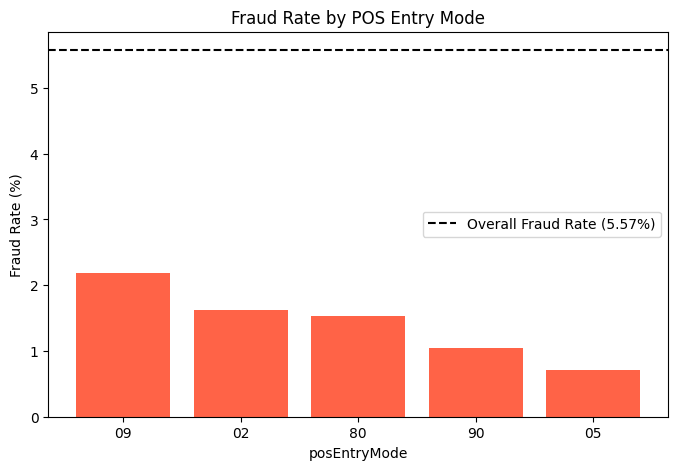

In [ ]:
counts = data['posEntryMode'].value_counts()
counts
data.groupby('posEntryMode')['isFraud'].mean().sort_values(ascending=False)

import matplotlib.pyplot as plt

fraud_rates = {
    "09": 0.021909,
    "02": 0.016152,
    "80": 0.015385,
    "90": 0.010397,
    "05": 0.007058
}

plt.figure(figsize=(8,5))
plt.bar(fraud_rates.keys(), [v*100 for v in fraud_rates.values()], color="tomato")
plt.axhline(5.5749, color="black", linestyle="--", label="Overall Fraud Rate (5.57%)")

plt.xlabel("posEntryMode")
plt.ylabel("Fraud Rate (%)")
plt.title("Fraud Rate by POS Entry Mode")
plt.legend()
plt.show()



**Customer_Spending_Patterns**

In [16]:
data["credit_utilization"] = data["transactionAmount"] / (data["availableMoney"] + 1)

**Merchant Level Risk Features**

In [17]:
data["merchant_total_txns"] = data.groupby("merchantName")["transactionAmount"].transform("count")

In [18]:
data["merchant_avg_amt"] = data.groupby("merchantName")["transactionAmount"].transform("mean")

In [19]:
data["merchant_fraud_rate"] = data.groupby("merchantName")["isFraud"].transform("mean")

**Transaction_level_Patterns**

In [20]:
data["avg_txn_amt_card"] = data.groupby("accountNumber")["transactionAmount"].transform("mean")
data["std_txn_amt_card"] = data.groupby("accountNumber")["transactionAmount"].transform("std")
data["amt_deviation"] = (data["transactionAmount"] - data["avg_txn_amt_card"]) / (data["std_txn_amt_card"] + 1)

The fraud rate varies by POS entry mode, with mode 09 showing the highest fraud rate (~2.2%), while mode 05 exhibits the lowest.
However, all modes have a fraud rate below the overall average of 5.57%, suggesting that POS-based fraud is relatively contained compared to other channels.
This may indicate stronger fraud controls or verification mechanisms within physical or chip-based POS transactions.”

**Lets identify ranges where fraud rate increases for Creditlimit, transactionAmount and currentBalance.**

In [21]:

# Define your columns of interest
cols_to_check = ['creditLimit', 'transactionAmount', 'currentBalance']

# Set the step size for thresholds (adjust for granularity)
threshold_steps = 20  # percentiles from 10% to 90%

# Loop over each column
for col in cols_to_check:
    print(f"\n📊 Fraud Rate Analysis for: {col}")
    print("-" * 40)

    # Get min and max thresholds using percentiles
    for percentile in range(10, 100, threshold_steps):
        threshold = data[col].quantile(percentile / 100)

        fraud_rate_above = data[data[col] > threshold]['isFraud'].mean()
        fraud_rate_below = data[data[col] <= threshold]['isFraud'].mean()

        print(f"Threshold > {percentile}% ({threshold:.2f}) → Fraud Rate: {fraud_rate_above:.4f}")



📊 Fraud Rate Analysis for: creditLimit
----------------------------------------
Threshold > 10% (500.00) → Fraud Rate: 0.0139
Threshold > 30% (2500.00) → Fraud Rate: 0.0112
Threshold > 50% (5000.00) → Fraud Rate: 0.0093
Threshold > 70% (10000.00) → Fraud Rate: 0.0086
Threshold > 90% (15000.00) → Fraud Rate: 0.0012

📊 Fraud Rate Analysis for: transactionAmount
----------------------------------------
Threshold > 10% (8.75) → Fraud Rate: 0.0154
Threshold > 30% (41.98) → Fraud Rate: 0.0174
Threshold > 50% (86.66) → Fraud Rate: 0.0201
Threshold > 70% (163.02) → Fraud Rate: 0.0220
Threshold > 90% (328.59) → Fraud Rate: 0.0269

📊 Fraud Rate Analysis for: currentBalance
----------------------------------------
Threshold > 10% (41.69) → Fraud Rate: 0.0143
Threshold > 30% (376.50) → Fraud Rate: 0.0152
Threshold > 50% (1086.97) → Fraud Rate: 0.0142
Threshold > 70% (2593.46) → Fraud Rate: 0.0111
Threshold > 90% (8532.53) → Fraud Rate: 0.0074


Fraud rate remains relatively stable (~1.5–1.7%) until very high credit limits  20,000.

A sharp rise at 90% suggests that very high credit limits are associated with elevated fraud risk — possibly due to opportunistic misuse.

**Insight:** Monitor accounts with exceptionally high credit limits, as they show twice the average fraud rate.

Fraud rate steadily increases with transaction size.
With $329, fraud rate more than doubles from the base level.

**Insight:** Larger transactions are consistently riskier — a clear positive relationship between amount and fraud likelihood.

Fraud rates rise with higher transaction amounts and credit limits, showing that larger transactions and high-limit accounts are more prone to fraud.

### **TOP 10 MERCHANTS BY THE FRAUD RATE:**

In [23]:
data['fraud_amount'] = data['transactionAmount'] * data['isFraud']

merchant_fraud = (
    data.groupby('merchantName', as_index=False)
      .agg(
          total_txns=('isFraud', 'count'),
          fraud_txns=('isFraud', 'sum'),
          fraud_rate=('isFraud', 'mean'),
          fraud_amount=('fraud_amount', 'sum')
      )
      .sort_values(by='fraud_rate', ascending=False)
)

merchant_fraud.head(8)


,merchantName,total_txns,fraud_txns,fraud_rate,fraud_amount
1252,Quizno's #604182,1,1,1.000000,124.78
592,Hardee's #398938,1,1,1.000000,294.52
422,Dunkin' Donuts #48174,3,2,0.666667,0.00
316,Domino's Pizza #225172,2,1,0.500000,126.61
391,Dunkin' Donuts #08264,2,1,0.500000,292.71
393,Dunkin' Donuts #159114,2,1,0.500000,130.03
1386,Rodeway Inn #981618,2,1,0.500000,0.57
1527,Subway #401837,2,1,0.500000,593.13


Analysed merchant level patterns, American Airlines Showed high fraud rate and followed by IN AND OUT,  indicating vulnerablities at specific outlets.

### **TOP 10 MERCHANTS BY THE FRAUD TRANSACTIONS  FRAUD AMOUNT:**

In [24]:
top_merchants = (
    data.assign(fraud_amount=data['transactionAmount'] * data['isFraud'])
        .groupby('merchantName', as_index=False)
        .agg(
            total_txns=('isFraud', 'size'),
            fraud_txns=('isFraud', 'sum'),
            total_amount=('transactionAmount', 'sum'),
            fraud_amount=('fraud_amount', 'sum')
        )
        .assign(fraud_rate=lambda d: d['fraud_txns'] / d['total_txns'])
        .nlargest(10, 'fraud_txns')[['merchantName', 'fraud_rate', 'fraud_txns', 'fraud_amount']]
)

print(top_merchants)


       merchantName  fraud_rate  fraud_txns  fraud_amount
2015    walmart.com    0.096618          40       7392.71
1654           Uber    0.018433          16       4751.64
2004       ebay.com    0.029817          13       2534.86
885            Lyft    0.011429          10       2575.26
2006        gap.com    0.021598          10       2970.07
2002  cheapfast.com    0.019956           9       2811.85
2012      sears.com    0.020642           9       2204.51
2000      apple.com    0.018349           8       2112.49
498    Fresh eCards    0.074074           6       1594.65
2010    oldnavy.com    0.012987           6       1140.19


“**The top merchants by fraud volume include Ebay, Lyft,Uber, Sears and Walmart, Staples and discount.

Fraud losses are concentrated among large, high-volume merchants, with several well-known e-commerce and transportation platforms. (From 22k to 57K)  




Fraud risk isn’t just about frequency — it’s a combination of rate, transaction volume, and dollar loss.

 ### **Merchants list by hourly and Temporal Patterns**  

In [28]:
import numpy as np

TOP_K = 3  # adjust as needed

# Aggregate including accountNumber
agg = (
    data.assign(
        isFraud=lambda d: d['isFraud'].astype('i1'),
        fraud_amount=lambda d: d['transactionAmount'] * d['isFraud'],
    )
    .groupby(['Trans_Hour', 'merchantName', 'accountNumber'], as_index=False)
    .agg(
        total_txns=('isFraud', 'size'),
        fraud_txns=('isFraud', 'sum'),
        total_amount=('transactionAmount', 'sum'),
        fraud_amount=('fraud_amount', 'sum'),
    )
)

# % fraud amount out of total amount (safe divide)
agg['pct_fraud_amount'] = np.divide(
    agg['fraud_amount'],
    agg['total_amount'],
    out=np.zeros(len(agg), dtype=float),
    where=agg['total_amount'].ne(0)
)

# Top-K merchants per hour by fraud_amount
top_idx = (
    agg.groupby('Trans_Hour')['fraud_amount']
       .nlargest(TOP_K)
       .index.get_level_values(1)
)

top_merchants_per_hour = (
    agg.loc[top_idx]
       .sort_values(['Trans_Hour', 'fraud_amount'], ascending=[True, False])
)

# Preview
top_merchants_per_hour.head(25)




,Trans_Hour,merchantName,accountNumber,total_txns,fraud_txns,total_amount,fraud_amount,pct_fraud_amount
600,0,target.com,346419123,3,1,503.07,429.54,0.853837
9,0,34th BBQ #192302,686661552,1,1,317.01,317.01,1.000000
614,0,walmart.com,525304407,1,1,304.59,304.59,1.000000
789,1,Fresh eCards,745217385,1,1,373.11,373.11,1.000000
837,1,Lyft,863456981,14,1,1488.65,370.29,0.248742
1217,1,walmart.com,119877862,1,1,317.89,317.89,1.000000
1812,2,walmart.com,996362843,2,2,962.14,962.14,1.000000
1600,2,Uber,386732203,7,2,1383.61,823.78,0.595385
1493,2,Planet Fitness #136615,114896048,1,1,406.89,406.89,1.000000
2000,3,Hardee's #398938,588455587,1,1,294.52,294.52,1.000000


Together they give insight into velocity and volume of spending.

**Total Transactions per account per hour**  

In [26]:
data['txn_count_hour'] = (
    data.groupby(['accountNumber', 'Trans_Hour'])['transactionAmount']
      .transform('count')
)


In [27]:
# Sum of amounts per account per hour
data['amt_sum_hour'] = (
    data.groupby(['accountNumber', 'Trans_Hour'])['transactionAmount']
      .transform('sum')
)

### **FEATURE ENGINEERING**

**Generating New Features from Date and Time Columns**

---



In [25]:
data['Trans_Hour'] = data['transactionDateTime'].dt.hour
data["is_night"] = data["Trans_Hour"].isin([0,1,2,3,4,5]).astype(int)

In [29]:
# Drop the original columns
df = data.drop(['currentExpDate', 'accountOpenDate','expirationDateKeyInMatch'], axis=1)

In [30]:
df

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,merchantCategoryCode,...,merchant_avg_amt,merchant_fraud_rate,avg_txn_amt_card,std_txn_amt_card,amt_deviation,fraud_amount,Trans_Hour,is_night,txn_count_hour,amt_sum_hour
0,737265056,5000.0,5000.00,2016-08-13 14:27:32,98.55,Uber,US,US,02,rideshare,...,149.957972,0.018433,47.000000,46.688487,1.080974,0.0,14,0,1,98.55
1,737265056,5000.0,5000.00,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,entertainment,...,131.317108,0.012048,47.000000,46.688487,0.576869,0.0,5,1,1,74.51
2,737265056,5000.0,5000.00,2016-11-08 09:18:39,7.47,Play Store,US,US,09,mobileapps,...,5.904884,0.000000,47.000000,46.688487,-0.828921,0.0,9,0,1,7.47
3,737265056,5000.0,5000.00,2016-12-10 02:14:50,7.47,Play Store,US,US,09,mobileapps,...,5.904884,0.000000,47.000000,46.688487,-0.828921,0.0,2,1,1,7.47
4,830329091,5000.0,5000.00,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,fastfood,...,185.596667,0.000000,107.255455,147.101379,-0.243586,0.0,21,0,1,71.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18945,380503025,2500.0,1107.22,2016-11-26 18:52:37,238.60,Wendys #101984,US,US,05,fastfood,...,121.360000,0.000000,148.750808,151.377993,0.589647,0.0,18,0,47,6301.10
18946,380503025,2500.0,868.62,2016-11-26 19:42:28,227.25,Subway #817052,US,US,05,fastfood,...,147.605000,0.000000,148.750808,151.377993,0.515161,0.0,19,0,43,6707.92
18947,380503025,2500.0,641.37,2016-11-26 19:50:48,78.89,McDonalds #604303,US,US,05,fastfood,...,78.890000,0.000000,148.750808,151.377993,-0.458470,0.0,19,0,43,6707.92
18948,380503025,2500.0,562.48,2016-11-27 00:29:39,26.83,Starbucks #587257,US,US,02,fastfood,...,26.830000,0.000000,148.750808,151.377993,-0.800121,0.0,0,1,45,6970.33


Extracted the transaction hour from the transactionDateTime column to analyze time-based patterns in fraud (e.g., late-night transactions).

Created a binary feature is_night to flag transactions occurring between 12 AM and 6 AM, since fraudulent activities are often higher during odd hours.

Generated a new feature validity_days (and validity_years) by calculating the difference between account opening and expiry date — this helps understand how long an account has been active, which can influence fraud risk.

Dropped the original date columns (currentExpDate, accountOpenDate, etc.) after deriving useful features from them to reduce redundancy.

Extracted transaction date, year, and month name to capture potential seasonal or monthly trends in fraudulent transactions

In [25]:
df = df.drop(['dateOfLastAddressChange', 'transactionDateTime'], axis=1)
df

,accountNumber,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,merchantCategoryCode,transactionType,...,credit_utilization,merchant_total_txns,merchant_avg_amt,merchant_fraud_rate,avg_txn_amt_card,std_txn_amt_card,amt_deviation,fraud_amount,Trans_Hour,is_night
0,737265056,5000.0,5000.00,98.55,Uber,US,US,02,rideshare,PURCHASE,...,0.019706,6213,143.923489,0.024465,47.000000,46.688487,1.080974,0.0,14,0
1,737265056,5000.0,5000.00,74.51,AMC #191138,US,US,09,entertainment,PURCHASE,...,0.014899,927,140.639245,0.004315,47.000000,46.688487,0.576869,0.0,5,1
2,737265056,5000.0,5000.00,7.47,Play Store,US,US,09,mobileapps,PURCHASE,...,0.001494,1675,5.896997,0.000000,47.000000,46.688487,-0.828921,0.0,9,0
3,737265056,5000.0,5000.00,7.47,Play Store,US,US,09,mobileapps,PURCHASE,...,0.001494,1675,5.896997,0.000000,47.000000,46.688487,-0.828921,0.0,2,1
4,830329091,5000.0,5000.00,71.18,Tim Hortons #947751,US,US,02,fastfood,PURCHASE,...,0.014233,28,154.187500,0.000000,107.255455,147.101379,-0.243586,0.0,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170440,225678947,2500.0,494.12,0.00,Uptown Diner,US,US,,food,ADDRESS_VERIFICATION,...,0.000000,199,156.563869,0.015075,141.154281,148.143162,-0.946435,0.0,15,0
170441,225678947,2500.0,494.12,286.92,34th BBQ #538716,US,US,05,food,PURCHASE,...,0.579496,170,138.282412,0.000000,141.154281,148.143162,0.977354,0.0,16,0
170442,225678947,2500.0,207.20,65.65,34th BBQ #538716,US,US,05,food,PURCHASE,...,0.315322,170,138.282412,0.000000,141.154281,148.143162,-0.506254,0.0,17,0
170443,225678947,2500.0,141.55,585.79,AMC #145832,US,US,05,entertainment,PURCHASE,...,4.109365,925,149.595362,0.008649,141.154281,148.143162,2.981268,0.0,20,0


In [28]:
merchant_check = (
    df.groupby(['accountNumber', 'Trans_Hour'])['merchantCategoryCode']
      .nunique()
      .reset_index(name='unique_merchant_categories')
)

merchant_check

,accountNumber,Trans_Hour,unique_merchant_categories
0,100328049,0,2
1,100328049,1,1
2,100328049,2,3
3,100328049,3,4
4,100328049,4,4
...,...,...,...
21311,999389635,13,1
21312,999389635,14,1
21313,999389635,15,1
21314,999389635,16,1


In [29]:
df['is_reverse'] = (df['transactionType'] == 'REVERSAL').astype(int)
df['is_multiswipe'] = (df['transactionType'] == 'MULTISWIPE').astype(int)

account_features = (
    df.groupby('accountNumber')
      .agg(
          reverse_count=('is_reverse', 'sum'),
          multiswipe_count=('is_multiswipe', 'sum'),
          total_txn=('transactionAmount', 'count')
      )
      .reset_index()
)


In [30]:
night_features = (
    df.groupby('accountNumber')['is_night']
      .sum()
      .reset_index(name='night_txn_count')
)

In [31]:
category_sum = (
    df.groupby('merchantCategoryCode')['transactionAmount']
      .sum()
      .reset_index(name='category_total_txn_amt')
)


In [32]:
fraud_sum_account = (
    df.groupby('accountNumber')['fraud_amount']
      .sum()
      .reset_index(name='fraud_sum_account')
)


In [31]:
# Fraud flag
df['is_fraud'] = (df['fraud_amount'] > 0).astype(int)

# Reverse and multiswipe flags
df['is_reverse'] = (df['transactionType'] == 'REVERSAL').astype(int)
df['is_multiswipe'] = (df['transactionType'] == 'MULTISWIPE').astype(int)

# Fraud amount per account
fraud_sum = df.groupby('accountNumber')['fraud_amount'].sum().reset_index(name='fraud_sum_account')

# Total amount per merchant category
cat_sum = df.groupby('merchantCategoryCode')['transactionAmount'].sum().reset_index(name='category_total_txn_amt')

# Night transactions per account
night_sum = df.groupby('accountNumber')['is_night'].sum().reset_index(name='night_txn_count')

# Reverse & multiswipe totals per account
rev_multi = df.groupby('accountNumber').agg(
    reverse_amt=('transactionAmount', lambda x: x[df.loc[x.index, 'is_reverse']==1].sum()),
    multiswipe_amt=('transactionAmount', lambda x: x[df.loc[x.index, 'is_multiswipe']==1].sum())
).reset_index()

# Merge all features back
df = (df.merge(fraud_sum, on='accountNumber', how='left')
        .merge(cat_sum, on='merchantCategoryCode', how='left')
        .merge(night_sum, on='accountNumber', how='left')
        .merge(rev_multi, on='accountNumber', how='left'))


In [32]:
df

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,merchantCategoryCode,...,txn_count_hour,amt_sum_hour,is_fraud,is_reverse,is_multiswipe,fraud_sum_account,category_total_txn_amt,night_txn_count,reverse_amt,multiswipe_amt
0,737265056,5000.0,5000.00,2016-08-13 14:27:32,98.55,Uber,US,US,02,rideshare,...,1,98.55,0,0,0,0.00,254192.86,2,0.00,0.0
1,737265056,5000.0,5000.00,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,entertainment,...,1,74.51,0,0,0,0.00,294708.89,2,0.00,0.0
2,737265056,5000.0,5000.00,2016-11-08 09:18:39,7.47,Play Store,US,US,09,mobileapps,...,1,7.47,0,0,0,0.00,2349.92,2,0.00,0.0
3,737265056,5000.0,5000.00,2016-12-10 02:14:50,7.47,Play Store,US,US,09,mobileapps,...,1,7.47,0,0,0,0.00,2349.92,2,0.00,0.0
4,830329091,5000.0,5000.00,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,fastfood,...,1,71.18,0,0,0,0.00,492092.22,2,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18945,380503025,2500.0,1107.22,2016-11-26 18:52:37,238.60,Wendys #101984,US,US,05,fastfood,...,47,6301.10,0,0,0,2123.45,492092.22,265,4388.51,0.0
18946,380503025,2500.0,868.62,2016-11-26 19:42:28,227.25,Subway #817052,US,US,05,fastfood,...,43,6707.92,0,0,0,2123.45,492092.22,265,4388.51,0.0
18947,380503025,2500.0,641.37,2016-11-26 19:50:48,78.89,McDonalds #604303,US,US,05,fastfood,...,43,6707.92,0,0,0,2123.45,492092.22,265,4388.51,0.0
18948,380503025,2500.0,562.48,2016-11-27 00:29:39,26.83,Starbucks #587257,US,US,02,fastfood,...,45,6970.33,0,0,0,2123.45,492092.22,265,4388.51,0.0


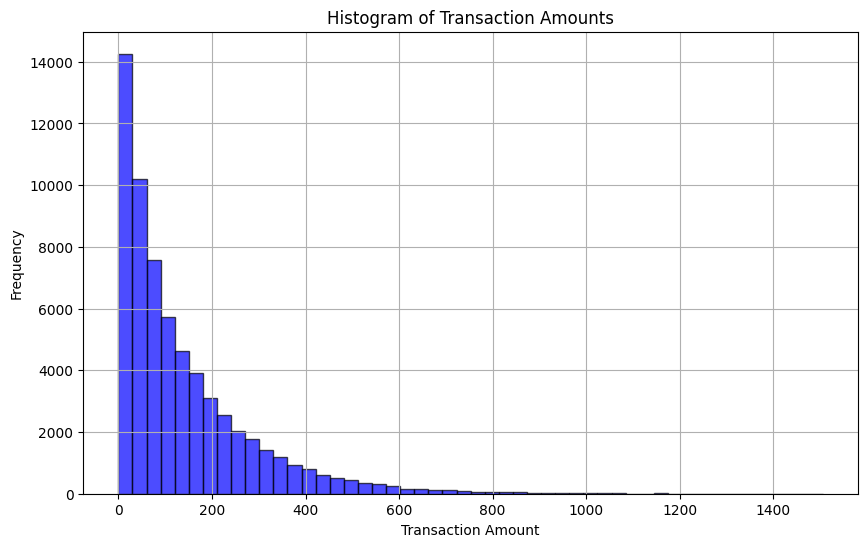

Transaction Amount Summary:
count    63577.000000
mean       138.573092
std        148.143406
min          0.000000
25%         34.720000
50%         89.160000
75%        193.340000
max       1505.850000
Name: transactionAmount, dtype: float64


In [ ]:
import matplotlib.pyplot as plt

# Plot histogram for transactionAmount
plt.figure(figsize=(10, 6))
plt.hist(df["transactionAmount"], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Transaction Amounts")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Statistical description of transactionAmount
transaction_stats = df["transactionAmount"].describe()
print("Transaction Amount Summary:")
print(transaction_stats)

In [33]:
df.columns

Index(['accountNumber', 'creditLimit', 'availableMoney', 'transactionDateTime',
       'transactionAmount', 'merchantName', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'merchantCategoryCode',
       'dateOfLastAddressChange', 'transactionType', 'currentBalance',
       'cardPresent', 'isFraud', 'cvv_match', 'credit_utilization',
       'merchant_total_txns', 'merchant_avg_amt', 'merchant_fraud_rate',
       'avg_txn_amt_card', 'std_txn_amt_card', 'amt_deviation', 'fraud_amount',
       'Trans_Hour', 'is_night', 'txn_count_hour', 'amt_sum_hour', 'is_fraud',
       'is_reverse', 'is_multiswipe', 'fraud_sum_account',
       'category_total_txn_amt', 'night_txn_count', 'reverse_amt',
       'multiswipe_amt'],
      dtype='object')

The histogram above illustrates the distribution of transaction amounts and their frequency. The data shows that transaction peaks occur predominantly for amounts less than **250,** with a mean transaction value of **136.** Additionally, **75%** of users spend **191** or less on their transactions, indicating that the majority of users make transactions below **200**. If later we see any spends above then this 75% it may indicate fraudulent transaction.

### **Data Transformation & Pipeline Setup**  

In [34]:
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    precision_recall_curve, accuracy_score, f1_score
)
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# =========================
# Assume df already exists with your listed columns
# If not, load it here, e.g.:
# df = pd.read_csv("your_file.csv")
# =========================

# Safety: normalize transactionType and ensure flags exist (no-ops if already present)
df["transactionType"] = df["transactionType"].astype(str).str.upper()
if "is_reverse" not in df.columns:
    df["is_reverse"] = (df["transactionType"] == "REVERSAL").astype(int)
if "is_multiswipe" not in df.columns:
    df["is_multiswipe"] = (df["transactionType"] == "MULTISWIPE").astype(int)
if "merchantName_top" not in df.columns:
    df["merchantName_top"] = df["merchantName"].astype(str)

# =========================
# Target and feature selection (avoid leakage: don't use 'is_fraud' or 'fraud_amount')
# =========================
y_full = df["isFraud"].astype(int).copy()

# CATEGORICAL (string-like)
categorical_cols = [
    "acqCountry","merchantCountryCode","posEntryMode",
    "merchantCategoryCode","transactionType","merchantName_top"
]

# BINARY flags
binary_cols = ["cardPresent","cvv_match","is_night","is_reverse","is_multiswipe"]

# NUMERIC (standard scale)
num_cols = [
    "creditLimit","availableMoney","Trans_Hour",
    "merchant_avg_amt","credit_utilization","avg_txn_amt_card","std_txn_amt_card",
    "amt_deviation"
]

# LOG-NUMERIC (skewed → log1p then scale)
log_num_cols = [
    "transactionAmount","currentBalance","merchant_total_txns",
    "reverse_amt","multiswipe_amt",
    "fraud_sum_account","category_total_txn_amt","night_txn_count",
    "txn_count_hour","amt_sum_hour"
]

# Keep stable order
feature_order = num_cols + log_num_cols + categorical_cols + binary_cols
X_full = df[feature_order].copy()

# =========================
# Split (train/test)
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# =========================
# Top-N merchant mapping (train-only)
# =========================
TOP_N = 200
top_merchants = (
    X_train["merchantName_top"].astype(str).value_counts().head(TOP_N).index.tolist()
)

def map_top_other(s, top_list):
    s = s.astype(str)
    return np.where(s.isin(top_list), s, "other")

X_train["merchantName_top"] = map_top_other(X_train["merchantName_top"], top_merchants)
X_test["merchantName_top"]  = map_top_other(X_test["merchantName_top"],  top_merchants)

# =========================
# Preprocessing pipelines
# =========================
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=True))
])

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

log_numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, validate=False)),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num",     numeric_transformer,     num_cols),
        ("log_num", log_numeric_transformer, log_num_cols),
        ("cat",     categorical_transformer, categorical_cols),
        ("bin",     "passthrough",           binary_cols),
    ],
    sparse_threshold=1.0
)

# =========================
# Model pipeline
# =========================
logreg_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", solver="saga"))
])

# =========================
# Threshold tuning on a validation split
# =========================
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Fit on sub-train
logreg_pipe.fit(X_tr, y_tr)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=1.0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['creditLimit',
                                                   'availableMoney',
                                                   'Trans_Hour',
                                                   'merchant_avg_amt',
                                                   'credit_utilization',
                                                   'avg_txn_amt_card',
                                                   'std_txn_amt_card',
                                                   'amt_deviation']),
                                                 ('log_num',
                                                  Pipeline(steps=...
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['acqCountry',
                                                   'merchantCountryCode',
                                                   'posEntryMode',
                                                   'merchantCategoryCode',
                                                   'transactionType',
                                                   'merchantName_top']),
                                                 ('bin', 'passthrough',
                                                  ['cardPresent', 'cvv_match',
                                                   'is_night', 'is_reverse',
                                                   'is_multiswipe'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='saga'))])

In [35]:
# Choose threshold on validation by F1 (change to cost if you want)
y_val_proba = logreg_pipe.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
thresholds = np.r_[thresholds, 1.0]
f1 = 2 * precision * recall / (precision + recall + 1e-12)
best_idx = int(np.nanargmax(f1))
best_threshold = float(thresholds[best_idx])
print("Chosen threshold (F1 on validation):", best_threshold)

# Refit on full training
logreg_pipe.fit(X_train, y_train)

# --- Evaluate on TEST with tuned threshold
y_pred_proba_test = logreg_pipe.predict_proba(X_test)[:, 1]
y_pred_test = (y_pred_proba_test >= best_threshold).astype(int)

Chosen threshold (F1 on validation): 0.9471869039481081


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


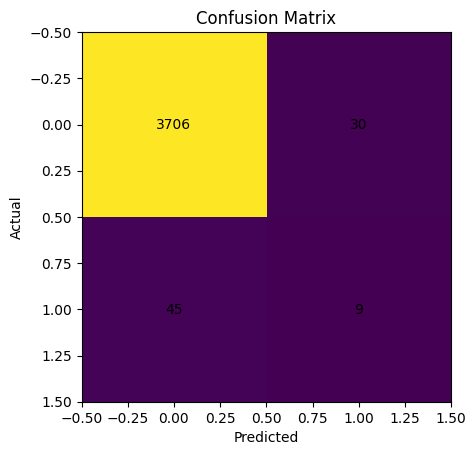

In [36]:
# Optional: quick heatmap (matplotlib only)
cm = confusion_matrix(y_test, y_pred_test)
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.show()


Data is fitting so well on training data, and not able to generalize well on test data, high bias and low variance. We can use xgboost to lower the bias.  

### **Modeling & Hyperparameter Tuning**

**XGBOOST:**

In [37]:
from sklearn.pipeline import Pipeline   # Corrected alias
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# XGBoost pipeline
xgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),  # reuse your existing preprocessor
    ("model", XGBClassifier(
        n_estimators=700,
        max_depth=5,
        learning_rate=0.04,
        subsample=0.6,
        colsample_bytree=0.6,
        random_state=42,
        scale_pos_weight=(
            len(y_train[y_train == 0]) / len(y_train[y_train == 1])
        ),
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric="logloss"  # avoids warnings
    ))
])

# Train model
xgb_pipe.fit(X_train, y_train)

# Predictions
xgb_pred = xgb_pipe.predict(X_test)
xgb_proba = xgb_pipe.predict_proba(X_test)[:, 1]

# Evaluation
print("XGBoost Classifier")
print(classification_report(y_test, xgb_pred))
print("ROC AUC:", roc_auc_score(y_test, xgb_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:33:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3736
           1       0.28      0.43      0.34        54

    accuracy                           0.98      3790
   macro avg       0.64      0.71      0.66      3790
weighted avg       0.98      0.98      0.98      3790

ROC AUC: 0.9083045840272821
Confusion Matrix:
 [[3678   58]
 [  31   23]]


In [38]:
# -------------------------
# XGBoost pipeline (same preprocessor)
# -------------------------
from xgboost import XGBClassifier
xgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        n_estimators=700,
        max_depth=5,
        learning_rate=0.04,
        subsample=0.6,
        colsample_bytree=0.6,
        random_state=42,
        scale_pos_weight=(len(y_train[y_train == 0]) / max(1, len(y_train[y_train == 1]))),
        n_jobs=-1,
        eval_metric="logloss"
    ))
])

# Tune threshold for XGB on the same validation procedure
xgb_pipe.fit(X_tr, y_tr)
y_val_proba_xgb = xgb_pipe.predict_proba(X_val)[:, 1]
"""

precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba_xgb)
thresholds = np.r_[thresholds, 1.0]
f1 = 2 * precision * recall / (precision + recall + 1e-12)
best_idx_xgb = int(np.nanargmax(f1))
best_threshold_xgb = float(thresholds[best_idx_xgb])
print("Chosen XGB threshold (F1 on validation):", best_threshold_xgb)"""

best_threshold_xgb = 0.6

# Refit on full training
xgb_pipe.fit(X_train, y_train)

# Test
xgb_proba_test = xgb_pipe.predict_proba(X_test)[:, 1]
xgb_pred_test = (xgb_proba_test >= best_threshold_xgb).astype(int)

print("\nXGBoost — Test ROC AUC:", roc_auc_score(y_test, xgb_proba_test))
print("\nXGBoost — Test Classification Report:")
print(classification_report(y_test, xgb_pred_test))
print("\nXGBoost — Test Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred_test))


XGBoost — Test ROC AUC: 0.9083045840272821

XGBoost — Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3736
           1       0.33      0.41      0.37        54

    accuracy                           0.98      3790
   macro avg       0.66      0.70      0.68      3790
weighted avg       0.98      0.98      0.98      3790


XGBoost — Test Confusion Matrix:
 [[3692   44]
 [  32   22]]


In [39]:
import joblib

# save both the model and any supporting objects you’ll need later
bundle = {
    "xgb_pipe": xgb_pipe,
    "threshold": best_threshold_xgb,   # if you used 0.5 manually, this will be 0.5
    "top_merchants": top_merchants,    # your top N list from earlier
}

joblib.dump(bundle, "fraud_xgb_bundle.pkl")
print("✅ Model and metadata saved as fraud_xgb_bundle.pkl")


✅ Model and metadata saved as fraud_xgb_bundle.pkl


In [40]:
import joblib
import pandas as pd
import numpy as np

# load the full bundle
bundle = joblib.load("fraud_xgb_bundle.pkl")

xgb_pipe = bundle["xgb_pipe"]
threshold = bundle["threshold"]
top_merchants = bundle["top_merchants"]
print("✅ Model loaded successfully with threshold =", threshold)


✅ Model loaded successfully with threshold = 0.6


In [41]:
import pickle

xgb_pipe.named_steps['preprocessor'].feature_names_in_


array(['creditLimit', 'availableMoney', 'Trans_Hour', 'merchant_avg_amt',
       'credit_utilization', 'avg_txn_amt_card', 'std_txn_amt_card',
       'amt_deviation', 'transactionAmount', 'currentBalance',
       'merchant_total_txns', 'reverse_amt', 'multiswipe_amt',
       'fraud_sum_account', 'category_total_txn_amt', 'night_txn_count',
       'txn_count_hour', 'amt_sum_hour', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'merchantCategoryCode',
       'transactionType', 'merchantName_top', 'cardPresent', 'cvv_match',
       'is_night', 'is_reverse', 'is_multiswipe'], dtype=object)

In [ ]:
# ======================
# 1) Save bundle (model + threshold)
# ======================
import joblib

best_threshold_xgb = float(best_threshold_xgb)  # already 0.55 in your code
bundle = {
    "model": xgb_pipe,               # fitted Pipeline (preprocessor + XGB)
    "threshold": best_threshold_xgb  # your chosen cutoff
}
joblib.dump(bundle, "fraud_xgb_bundle.pkl")
print("Saved -> fraud_xgb_bundle.pkl")


Saved -> fraud_xgb_bundle.pkl


In [44]:
# ======================
# 2) Inference helpers
# ======================
import numpy as np
import pandas as pd

# If you want to enforce a canonical order (optional, but handy):
FEATURES = [
    'creditLimit', 'availableMoney', 'Trans_Hour', 'merchant_avg_amt',
       'credit_utilization', 'avg_txn_amt_card', 'std_txn_amt_card',
       'amt_deviation', 'transactionAmount', 'currentBalance',
       'merchant_total_txns', 'reverse_amt', 'multiswipe_amt',
       'fraud_sum_account', 'category_total_txn_amt', 'night_txn_count',
       'txn_count_hour', 'amt_sum_hour', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'merchantCategoryCode',
       'transactionType', 'merchantName_top', 'cardPresent', 'cvv_match',
       'is_night', 'is_reverse', 'is_multiswipe'
]

def score_dataframe(pipe, df, threshold, ensure_features=True):
    """Return probabilities and labels for a DataFrame with raw columns."""
    X = df.copy()
    if ensure_features:
        for c in FEATURES:
            if c not in X.columns:
                X[c] = np.nan
        X = X[FEATURES]
    probs = pipe.predict_proba(X)[:, 1]
    preds = (probs >= threshold).astype(int)
    out = X.copy()
    out["fraud_probability"] = probs
    out["prediction"] = preds
    return out

def score_record(pipe, record: dict, threshold):
    """Single dict -> one prediction row."""
    df = pd.DataFrame([record])
    out = score_dataframe(pipe, df, threshold)
    return float(out["fraud_probability"].iloc[0]), int(out["prediction"].iloc[0])


**Feature Importance**

In [42]:

def ct_feature_names(preprocessor: ColumnTransformer, input_cols):
    # 1) If supported, use the built-in method
    if hasattr(preprocessor, "get_feature_names_out"):
        try:
            return preprocessor.get_feature_names_out(input_features=input_cols)
        except Exception:
            pass

    # 2) Manual walk: handles OHE (via categories_) + passthrough + pipelines
    names = []
    used = set()

    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder" or trans == "drop":
            continue

        # normalize cols
        if isinstance(cols, slice):
            cols = list(input_cols[cols])
        elif isinstance(cols, (np.ndarray, list, tuple)):
            cols = list(cols)
        elif isinstance(cols, str):
            cols = [cols]

        used.update(cols)

        # unwrap Pipeline
        if isinstance(trans, Pipeline):
            trans = trans.steps[-1][1]

        # OneHotEncoder: build names from categories_
        if isinstance(trans, OneHotEncoder) and hasattr(trans, "categories_"):
            for c, cats in zip(cols, trans.categories_):
                for cat in cats:
                    names.append(f"onehot__{c}_{cat}")
            continue

        # Transformers without expansion (scaler, imputer, etc.) → one name per input
        names.extend(cols)

    # remainder passthrough
    if getattr(preprocessor, "remainder", None) == "passthrough":
        rem = [c for c in input_cols if c not in used]
        names.extend(rem)

    return np.array(names, dtype=object)

# ---- use it
pre = xgb_pipe.named_steps["preprocessor"]        # NOT the estimator
feature_names = ct_feature_names(pre, X_train.columns)
print(len(feature_names), feature_names[:10])


263 ['creditLimit' 'availableMoney' 'Trans_Hour' 'merchant_avg_amt'
 'credit_utilization' 'avg_txn_amt_card' 'std_txn_amt_card'
 'amt_deviation' 'transactionAmount' 'currentBalance']


In [ ]:
import pandas as pd

est = xgb_pipe.named_steps["model"]
booster = est.get_booster()
gain = booster.get_score(importance_type="gain")      # keys: f0, f1, ...
idx2name = {f"f{i}": n for i, n in enumerate(feature_names)}
feature_Importance_gain = (pd.Series({idx2name.get(k, k): v for k, v in gain.items()})
           .sort_values(ascending=False))
print(feature_Importance_gain.head(50))

onehot__merchantName_top_Boston Cafe #465229          195.612579
onehot__posEntryMode_90                               186.752014
onehot__merchantName_top_Ray's Fries #892291          172.929565
onehot__merchantCategoryCode_mobileapps               148.265594
onehot__merchantCategoryCode_entertainment            147.725601
onehot__merchantName_top_Best Pub                     138.622681
onehot__merchantName_top_discount.com                 129.010712
onehot__merchantCategoryCode_airline                  127.333710
onehot__merchantName_top_oldnavy.com                  120.752899
onehot__merchantName_top_Franks Pub #53336            113.641495
onehot__merchantName_top_Franks Pub #632075           112.680428
creditLimit                                           112.630997
onehot__merchantName_top_Shell Gas #898217            109.636688
merchant_total_txns                                   108.778824
onehot__merchantName_top_1st Sandwitch Bar #941288    108.454292
onehot__posEntryMode_    

In [43]:
feature_Importance_gain.to_csv("xgb_feature_importance_gain.csv")
print(feature_Importance_gain)


NameError: name 'feature_Importance_gain' is not defined

In [ ]:
# Save your feature importance to CSV
feature_Importance_gain.to_csv("xgb_feature_importance_gain.csv", header=["gain_importance"])
print("✅ File saved: xgb_feature_importance_gain.csv")


✅ File saved: xgb_feature_importance_gain.csv


**TOP PREDICTORS OF FRAUD:**
**Merchants and Peak Hours to Watch out:**

Uber, Lyft, Ebay.com, Walmart, discount, Gap and Sears consistently appeared in list where Fraud transaction volume and fraud counts were high. This evidented from the temporal analysis where hours like 12:00 AM, 01:00 AM and 03:00 AM were targeted mostly and these specific merchants showed fraudulent activity indicating low monitoring hours or bot testing.
